In [122]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold

file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv"
data = pd.read_csv(file_path)
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Text(0.5, 1.0, 'Distribution of obesity levels')

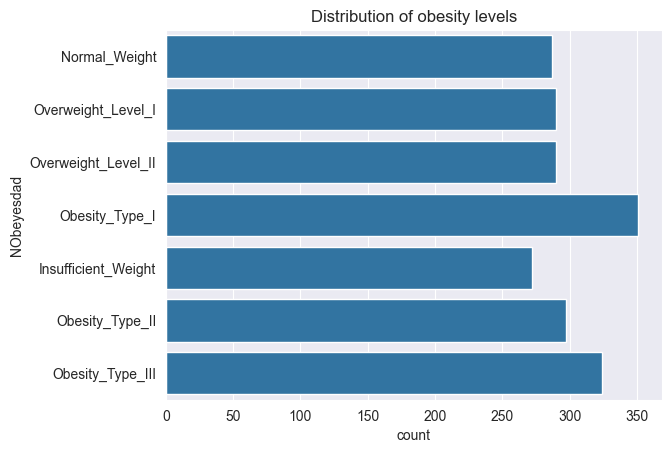

In [123]:
# Check classes labels are evenly distributed to avoid bias training.
sns.countplot(y="NObeyesdad", data=data)
plt.title("Distribution of obesity levels")

In [124]:
# Separate independent variable and target variable into different sets. Then split the data.
X = data.drop(columns=["NObeyesdad"])
y = data["NObeyesdad"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
# Extract the continuous column names from X_train
continuous_columns = X_train.select_dtypes(include=['float64']).columns

# Allow our scalar to learn the mean and standard deviation from the continuous columns of the X_train set
scaler = StandardScaler()
scaler.fit(X_train[continuous_columns])

# Apply this scalar to our X_train and X_test sets.
scaled_X_train_features = scaler.transform(X_train[continuous_columns])
scaled_X_test_features = scaler.transform(X_test[continuous_columns])

# Convert back to dataframes.
scaled_X_train_features = pd.DataFrame(scaled_X_train_features, columns=continuous_columns)
scaled_X_test_features = pd.DataFrame(scaled_X_test_features, columns=continuous_columns)

In [126]:
# Extract categorical columns
categorical_columns = X_train.select_dtypes(include=["object"]).columns

# Create encoder and have it return a dense np.array with the dummy variable trap removed. Then train the encoder.
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoder.fit(X_train[categorical_columns])

# Apply the learned encoder to our train and test set, converting our categorical values into binary values.
X_train_encoded = encoder.transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

# Convert back to dataframes
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_columns))
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate our scaled numeric columns and our encoded categorical columns to get our final X_train and X_test sets.
X_train_full = pd.concat([scaled_X_train_features, X_train_encoded], axis=1)
X_test_full = pd.concat([scaled_X_test_features, X_test_encoded], axis=1)

In [127]:
# Encode our target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data["NObeyesdad"])

In [128]:
# Extending usual binary classification logistic regression using a One-vs-All approach.
model_OvR = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model_OvR.fit(X_train_full, y_train)

# Find predictions
y_pred_OvR = model_OvR.predict(X_test_full)

# Evaluation metrics for OvA
print("One-vs-All (OvA) Strategy")
print(f"Accuracy: {np.round(100 * accuracy_score(y_test, y_pred_OvR), 2)}%")

One-vs-All (OvA) Strategy
Accuracy: 74.47%


In [129]:
# Extending usual binary classification logistic regression using a One-vs-One approach.
model_OvO = OneVsOneClassifier(LogisticRegression(max_iter=1000))
model_OvO.fit(X_train_full, y_train)

# Find predictions
y_pred_OvO = model_OvO.predict(X_test_full)

# Evaluation metrics for OvA
print("One-vs-one (OvO) strategy")
print(f"Accuracy = {np.round(100 * accuracy_score(y_pred_OvO, y_test), 2)}%")

One-vs-one (OvO) strategy
Accuracy = 93.38%
